## Testing multiple points of failure

This notebook forms the basis of "Hands-On 7" in the CCG course.

1. Show asset exposure based on flood return period maps, select all exposed assets in an area
    - note that if historic flood outlines are available, these could be used to select multiple assets instead
2. Demonstrate how the network effects of multiple asset failures would be disproportionately worse if there is no redundancy or potential for substitution. 
3. Understand the risk of multiple failures across the network - target the combinations of failures of greatest consequence

By the end of this tutorial you should be able to:
* Assess direct and some indirect impacts of multiple asset failures
* Compare flooding within regions as source of multiple failure scenarios
* Understand approaches to stress-testing the system under multiple failures

In [1]:
# Imports from Python standard library
import os
from math import factorial
from pathlib import Path

# Imports from other Python packages
import contextily as cx
import geopandas as gpd
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

# tqdm lets us show progress bars (and تقدّم means "progress" in Arabic)
# see https://tqdm.github.io/
from tqdm.notebook import tqdm
from tqdm.notebook import tqdm

Change this to point to your data folder as in the previous tutorial:

In [2]:
dir = Path().resolve().parent.parent
data_folder = dir / "ghana_tutorial"
# data_folder = Path("YOUR_PATH/ghana_tutorial")

In [3]:
# TODO add a note / auto download the geoboundaries dataset
# https://data.humdata.org/dataset/geoboundaries-admin-boundaries-for-ghana/resource/e324acb9-fd6b-4f5b-96ee-e2bb11917942

### 0.5  Preliminary step

Go to the geoboundatries at: https://www.geoboundaries.org/countryDownloads.html

Search for *Ghana* in the **Name** field and download the data set from **Source** Open Street Map. It will show up as a folder in your downloads directory. 

Put this folder in the data directory of this tutorial. The one you specify in the `data_folder` variable. # TODO add these steps to do this automatically - https://www.geoboundaries.org/api.html#api

In [4]:
# https://www.geoboundaries.org/api/current/gbOpen/GHA/ADM1/

import requests
import json
import zipfile

url = "https://www.geoboundaries.org/api/current/gbOpen/GHA/ADM1/"
response = requests.post(url)
test = json.loads(response.content)
download_url = test["staticDownloadLink"]
file_path = data_folder / "geoBoundaries-GHA-ADM1-all.zip"

if not file_path.exists():
    # note: this can take a few minutes for large files
    r = requests.get(download_url, stream=True)
    with open(file_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)

# extract the zip to the output directory
with zipfile.ZipFile(file_path, "r") as zip_ref:
    zip_ref.extractall(data_folder / "geoBoundaries-GHA-ADM1-all")

### 1. Map exposure

In [5]:
roads = gpd.read_file(data_folder / "GHA_OSM_roads.gpkg", layer="edges")
road_nodes = gpd.read_file(data_folder / "GHA_OSM_roads.gpkg", layer="nodes")

In [6]:
regions = gpd.read_file(
    os.path.join(
        data_folder,
        "geoBoundaries-GHA-ADM1-all",
        "geoBoundaries-GHA-ADM1.shp",
    )
)[["shapeName", "shapeISO", "geometry"]]

In [7]:
regions.head(5)

,shapeName,shapeISO,geometry
0,Western North Region,GH-WN,"POLYGON ((-2.57218 5.74991, -2.5708 5.71438, -..."
1,Ahafo Region,GH-AF,"POLYGON ((-2.42467 6.38815, -2.44938 6.39009, ..."
2,Bono East Region,GH-BE,"POLYGON ((-0.14542 7.9031, -0.14467 7.89674, -..."
3,Savannah Region,GH-SV,"POLYGON ((-0.38471 8.15282, -0.41897 8.15287, ..."
4,North East Region,GH-NE,"POLYGON ((-1.23184 10.01754, -1.27442 10.01619..."


In [8]:
roads = gpd.sjoin(roads, regions).drop(columns="index_right")

Filter roads by region name to find all roads in Greater Accra:

In [9]:
accra_roads = roads[roads.shapeName == "Greater Accra Region"]
accra_roads.head(5)

,osm_id,road_type,name,id,from_id,to_id,length_m,geometry,shapeName,shapeISO
0,4790594,tertiary,Airport Road,roade_0,roadn_0,roadn_1,236.526837,"LINESTRING (-0.17544 5.6055, -0.17418 5.60555,...",Greater Accra Region,GH-AA
1,4790599,tertiary,South Liberation Link,roade_1,roadn_2,roadn_10777,18.539418,"LINESTRING (-0.17889 5.59979, -0.17872 5.59977)",Greater Accra Region,GH-AA
2,4790599,tertiary,South Liberation Link,roade_2,roadn_10777,roadn_3,124.758045,"LINESTRING (-0.17872 5.59977, -0.17786 5.5996,...",Greater Accra Region,GH-AA
3,4790600,tertiary,Airport Road,roade_3,roadn_4,roadn_6313,38.030821,"LINESTRING (-0.1733 5.6056, -0.17327 5.60556, ...",Greater Accra Region,GH-AA
4,4790600,tertiary,Airport Road,roade_4,roadn_6313,roadn_6312,19.532483,"LINESTRING (-0.173 5.60559, -0.17299 5.60561, ...",Greater Accra Region,GH-AA


In [10]:
exposure = gpd.read_parquet(
    data_folder / "results" / "GHA_OSM_roads_edges___exposure.geoparquet"
)

In [11]:
exposure = gpd.sjoin(exposure, regions).drop(columns="index_right")

In [12]:
exposure.head(5)

,osm_id,road_type,name,id,from_id,to_id,length_m,geometry,split,i_0,...,wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00005-gha,wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00010-gha,wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00025-gha,wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00050-gha,wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00100-gha,wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00250-gha,wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00500-gha,wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp01000-gha,shapeName,shapeISO
0,4790594,tertiary,Airport Road,roade_0,roadn_0,roadn_1,48.717294,"LINESTRING (-0.17544 5.6055, -0.175 5.60552)",0,370,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Greater Accra Region,GH-AA
0,4790594,tertiary,Airport Road,roade_0,roadn_0,roadn_1,187.809543,"LINESTRING (-0.175 5.60552, -0.17418 5.60555, ...",1,371,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Greater Accra Region,GH-AA
1,4790599,tertiary,South Liberation Link,roade_1,roadn_2,roadn_10777,18.539418,"LINESTRING (-0.17889 5.59979, -0.17872 5.59977)",0,370,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Greater Accra Region,GH-AA
2,4790599,tertiary,South Liberation Link,roade_2,roadn_10777,roadn_3,124.758045,"LINESTRING (-0.17872 5.59977, -0.17786 5.5996,...",0,370,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Greater Accra Region,GH-AA
3,4790600,tertiary,Airport Road,roade_3,roadn_4,roadn_6313,38.030821,"LINESTRING (-0.1733 5.6056, -0.17327 5.60556, ...",0,371,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Greater Accra Region,GH-AA


Filter exposure by region, RCP and return period to find all roads exposed to a historical 100-year flood in Greater Accra:

In [13]:
accra_exposure = exposure[(exposure.shapeName == "Greater Accra Region")]

In [14]:
accra_exposure.head(5)

,osm_id,road_type,name,id,from_id,to_id,length_m,geometry,split,i_0,...,wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00005-gha,wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00010-gha,wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00025-gha,wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00050-gha,wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00100-gha,wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00250-gha,wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp00500-gha,wri_aqueduct-version_2-inunriver_rcp8p5_MIROC-ESM-CHEM_2080_rp01000-gha,shapeName,shapeISO
0,4790594,tertiary,Airport Road,roade_0,roadn_0,roadn_1,48.717294,"LINESTRING (-0.17544 5.6055, -0.175 5.60552)",0,370,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Greater Accra Region,GH-AA
0,4790594,tertiary,Airport Road,roade_0,roadn_0,roadn_1,187.809543,"LINESTRING (-0.175 5.60552, -0.17418 5.60555, ...",1,371,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Greater Accra Region,GH-AA
1,4790599,tertiary,South Liberation Link,roade_1,roadn_2,roadn_10777,18.539418,"LINESTRING (-0.17889 5.59979, -0.17872 5.59977)",0,370,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Greater Accra Region,GH-AA
2,4790599,tertiary,South Liberation Link,roade_2,roadn_10777,roadn_3,124.758045,"LINESTRING (-0.17872 5.59977, -0.17786 5.5996,...",0,370,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Greater Accra Region,GH-AA
3,4790600,tertiary,Airport Road,roade_3,roadn_4,roadn_6313,38.030821,"LINESTRING (-0.1733 5.6056, -0.17327 5.60556, ...",0,371,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Greater Accra Region,GH-AA


In [15]:
[col for col in accra_exposure.columns if "1980" in col]

['wri_aqueduct-version_2-inunriver_historical_000000000WATCH_1980_rp00002-gha',
 'wri_aqueduct-version_2-inunriver_historical_000000000WATCH_1980_rp00005-gha',
 'wri_aqueduct-version_2-inunriver_historical_000000000WATCH_1980_rp00010-gha',
 'wri_aqueduct-version_2-inunriver_historical_000000000WATCH_1980_rp00025-gha',
 'wri_aqueduct-version_2-inunriver_historical_000000000WATCH_1980_rp00050-gha',
 'wri_aqueduct-version_2-inunriver_historical_000000000WATCH_1980_rp00100-gha',
 'wri_aqueduct-version_2-inunriver_historical_000000000WATCH_1980_rp00250-gha',
 'wri_aqueduct-version_2-inunriver_historical_000000000WATCH_1980_rp00500-gha',
 'wri_aqueduct-version_2-inunriver_historical_000000000WATCH_1980_rp01000-gha']

<Axes: >

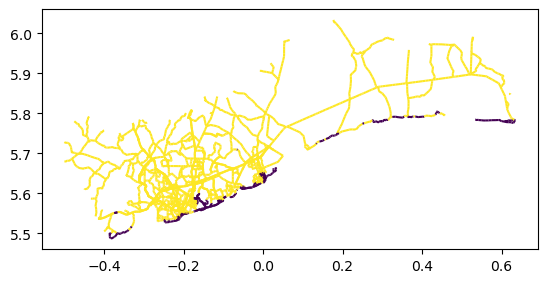

In [16]:
accra_exposure.plot(
    column="wri_aqueduct-version_2-inunriver_historical_000000000WATCH_1980_rp00100-gha"
)

In [17]:
flood_col = "wri_aqueduct-version_2-inunriver_historical_000000000WATCH_1980_rp00100-gha"
accra_exposure_100yr = accra_exposure[accra_exposure[flood_col] > 0.5].copy()
accra_exposure_100yr[["id", "road_type", "name", "length_m", flood_col]].head()

,id,road_type,name,length_m,wri_aqueduct-version_2-inunriver_historical_000000000WATCH_1980_rp00100-gha
126,roade_126,trunk,Winneba Road,364.644366,0.617383
126,roade_126,trunk,Winneba Road,158.050565,0.617383
127,roade_127,trunk,Winneba Road,54.297481,0.617383
128,roade_128,trunk,Winneba Road,715.652789,0.617383
128,roade_128,trunk,Winneba Road,360.198545,0.617383


### 2. Multiple failures

Direct damage can be summed directly, if we assume that all roads are damaged in the same event:

In [18]:
(
    "Total direct exposure, "
    "in Accra under a historical 100-year flood, is estimated to be "
    f"{int(accra_exposure_100yr.length_m.sum() // 1e3)}km (of {int(accra_exposure.length_m.sum() // 1e3)}km total roads)."
)

'Total direct exposure, in Accra under a historical 100-year flood, is estimated to be 199km (of 1959km total roads).'

Indirect damage can be assessed in different ways, some beyond the scope of this notebook. In this section, we look at the effects of disruption on a single route across the Greater Accra region. In a fuller analysis, we could extend this to look at many trips made within the region, and calculate the number of passengers or value of freight disrupted, along with the effects on transport time and cost.

Start by creating a networkx graph from the roads, using `from_id`, `to_id` and `length_m`:

In [19]:
G = nx.Graph()
G.add_edges_from(
    (r.from_id, r.to_id, {"id": r.id, "weight": r.length_m})
    for r in roads.itertuples()
)

Then find the shortest path from one node to another:

In [20]:
route_nodes = nx.algorithms.shortest_path(
    G, "roadn_6700", "roadn_1011", weight="weight"
)

Then find the edges in the shortest path, and sum over their lengths to find the length of the route:

In [21]:
def edge_ids_from_nodes(G, route_nodes):
    next_nodes = iter(route_nodes)
    next(next_nodes)
    return [G.edges[u, v]["id"] for u, v in zip(route_nodes, next_nodes)]


route_edge_ids = edge_ids_from_nodes(G, route_nodes)

In [22]:
route = roads[roads.id.isin(route_edge_ids)]

In [23]:
f"Best route: {round(route.length_m.sum() / 1e3, 2)}km"

'Best route: 5.24km'

<Axes: title={'center': 'Direct route'}>

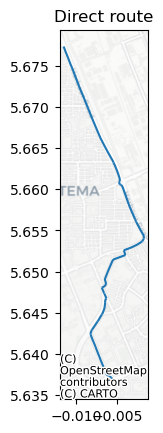

In [24]:
ax = route.plot()
ax.set_title("Direct route")
cx.add_basemap(ax, crs=route.crs, source=cx.providers.CartoDB.Positron)
ax

Save figure to file:

In [25]:
fig = ax.get_figure()
fig.savefig(os.path.join(data_folder, "results", "direct_route.png"))

Define a function which runs the process we went through above:
- build a graph
- reweight all failed edges to have infinite cost - failed edges need to be provided as a list of `("from_id", "to_id")` tuples.
- find the shortest route from source to target
- return a dataframe with the route's road segments

In [26]:
def calc_route(roads, failures, source, target):
    G = nx.Graph()
    G.add_edges_from(
        (r.from_id, r.to_id, {"id": r.id, "weight": r.length_m})
        for r in roads.itertuples()
    )

    reweight = {}
    for from_id, to_id in failures:
        reweight[(from_id, to_id)] = float("inf")
    nx.set_edge_attributes(G, reweight, "weight")

    route_nodes = nx.algorithms.shortest_path(
        G, source, target, weight="weight"
    )
    route_edge_ids = edge_ids_from_nodes(G, route_nodes)
    route = roads[roads.id.isin(route_edge_ids)]

    return route

In [27]:
def plot_route(df):
    ax = df.plot()
    cx.add_basemap(ax, crs=route.crs, source=cx.providers.CartoDB.Positron)
    return ax

Test a single road failure to find if disruption makes a difference to the overall route: 

Best route: 5.24km


<Axes: >

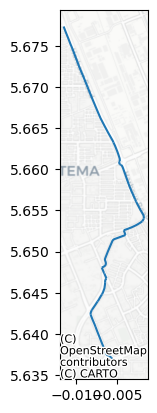

In [28]:
single_failures = [("roadn_8900", "roadn_9227")]
single_fail_route = calc_route(
    roads, single_failures, "roadn_6700", "roadn_1011"
)
print(f"Best route: {round(single_fail_route.length_m.sum() / 1e3, 2)}km")
plot_route(single_fail_route)

The single road failure above has almost no effect. In our dataset, the lanes of this road are represented separately, so the routing algorithm finds a route which goes around the failed link by switching to the other lane, and the whole journey is only about 10m longer. 

Let's see the effect of both lanes flooded at the same time, which may be more realistic:

Best route: 5.2km


<Axes: >

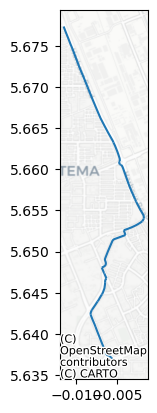

In [29]:
both_lanes_failures = [
    ("roadn_8900", "roadn_9227"),
    ("roadn_9226", "roadn_8899"),
]
both_lanes_fail_route = calc_route(
    roads, both_lanes_failures, "roadn_6700", "roadn_1011"
)
print(f"Best route: {round(both_lanes_fail_route.length_m.sum() / 1e3, 1)}km")
plot_route(both_lanes_fail_route)

This results in a much longer route around the flooded link.

What if more than one road is disrupted at the same time? Let's test what happens if we assume that all roads exposed to 1-in-100 year flood events anywhere in Greater Accra are impassible.

Best route: 6.3km


<Axes: >

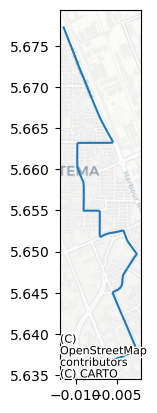

In [30]:
multi_failures = [
    (road.from_id, road.to_id) for road in accra_exposure.itertuples()
]
multi_fail_route = calc_route(
    roads, multi_failures, "roadn_6700", "roadn_1011"
)
print(f"Best route: {round(multi_fail_route.length_m.sum() / 1e3, 1)}km")
plot_route(multi_fail_route)

This gives a longer route again.

This is a quick way of coming up with a hypothetical flood event, but it is not a rigorous method of analysis. With historic flood outlines, we could test and validate this simple model against past events. With an event set output from a hydrological model (rather than just the return-period hazard map that we've been using),  we could test an ensemble of potential events.

The next section looks at testing all possible combinations of failures, which doesn't require any additional data or modelling. 

### 3. Test combinations 

We can calculate the number of possible combinations of failures, and it gets very large quite quickly. 

For example, with three roads, {A, B, C}, there are three possible single failures ({only A}, {only B} or {only C}), three possible double failures ({A and B}, {B and C} or {A and C}), and one possible triple failure ({A, B and C}).

More formally, if a set has $n$ elements, the number of ways of picking $k$ elements from it can be shown to be:

$$ {\binom {n}{k}}={\frac {n(n-1)\dotsb (n-k+1)}{k(k-1)\dotsb 1}}={\frac {n!}{k!(n-k)!}} $$

and is zero when $ k > n $.

The function `n_choose_k` calculates this:

In [31]:
def n_choose_k(n, k):
    if k > n:
        return 0
    return int(factorial(n) / (factorial(k) * factorial(n - k)))

Try out a few values to see how the function behaves:

In [32]:
n_choose_k(3, 2)

3

In [33]:
n_choose_k(200, 2)

19900

In [34]:
n_choose_k(200, 3)

1313400

Calculate some of the numbers of possible failure combinations within our road network:

In [35]:
n = len(roads)
print(f"With {n} roads")
for k in range(4):
    print(
        f"there are {n_choose_k(n, k):,} total possible combinations of {k} roads failing"
    )

With 16269 roads
there are 1 total possible combinations of 0 roads failing
there are 16,269 total possible combinations of 1 roads failing
there are 132,332,046 total possible combinations of 2 roads failing
there are 717,548,464,094 total possible combinations of 3 roads failing


Use the `np.random.choice` to sample failure combinations at random from all roads (regardless of whether they intersect with any hazard):

In [36]:
k = 500
ids = np.random.choice(roads.id, size=k, replace=False)
failed_roads = roads[roads.id.isin(ids)]
failed_roads.head(2)

,osm_id,road_type,name,id,from_id,to_id,length_m,geometry,shapeName,shapeISO
83,4845707,tertiary,Gukpegu Road,roade_83,roadn_1752,roadn_44,187.813305,"LINESTRING (-0.84425 9.40151, -0.84415 9.40152...",Northern Region,GH-NP
86,5019251,trunk,George Walker Bush Highway,roade_86,roadn_80,roadn_81,975.060718,"LINESTRING (-0.18862 5.61904, -0.18653 5.61972...",Greater Accra Region,GH-AA


Best route: 5.2km


<Axes: >

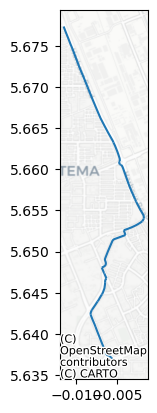

In [37]:
random_failures = [
    (road.from_id, road.to_id) for road in failed_roads.itertuples()
]
random_fail_route = calc_route(
    roads, random_failures, "roadn_6700", "roadn_1011"
)
print(f"Best route: {round(random_fail_route.length_m.sum() / 1e3, 1)}km")
plot_route(random_fail_route)

Sample 100 different sets of 500 failures to test how the best route length (for this arbitrarily-chosen route) changes under random failure conditions:

In [38]:
k = 500
n_samples = 100
lengths = []
for _ in tqdm(range(n_samples)):
    ids = np.random.choice(roads.id, size=k, replace=False)
    failed_roads = roads[roads.id.isin(ids)]
    random_failures = [
        (road.from_id, road.to_id) for road in failed_roads.itertuples()
    ]
    random_fail_route = calc_route(
        roads, random_failures, "roadn_6700", "roadn_1011"
    )
    length = round(random_fail_route.length_m.sum() / 1e3, 1)
    lengths.append(length)

  0%|          | 0/100 [00:00<?, ?it/s]

In [39]:
sampled_failures = pd.DataFrame({"length_km": lengths})

Calculate basic summary statistics from this sample:

In [40]:
sampled_failures.describe()

,length_km
count,100.000000
mean,5.388000
std,0.447954
min,5.200000
25%,5.200000
50%,5.300000
75%,5.400000
max,9.300000


Plot all the route lengths as a scatter plot, to get some visual idea of the distribution:

<Axes: xlabel='index', ylabel='length_km'>

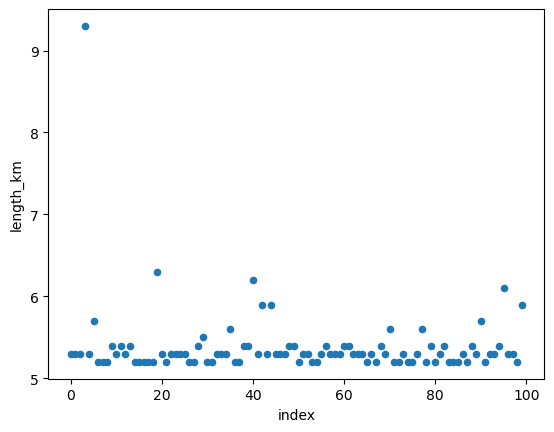

In [41]:
sampled_failures.reset_index().plot.scatter(x="index", y="length_km")

Plot the empirical cumulative distribution function to summarise the distribution in another way. 

In the samples we've taken while testing this tutorial, it shows most of the time 500 random failures in the road network has little effect on the route length (around 55-60km), but some combinations of failures see a route length of up to around 180km.

<Axes: xlabel='length_km', ylabel='Density'>

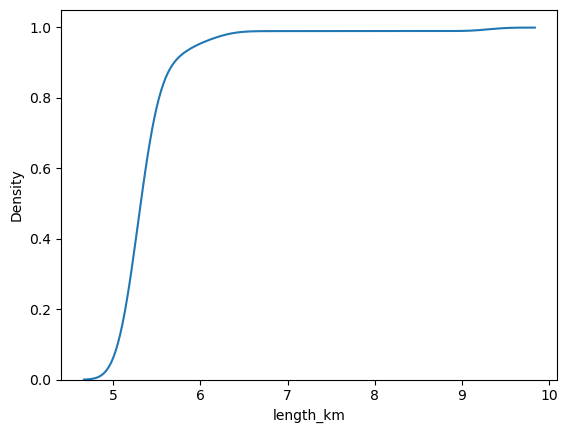

In [42]:
sns.kdeplot(sampled_failures.length_km, cumulative=True)